# Extracting Frames


In [3]:
# import os
# import cv2
# import json
# from tqdm import tqdm

# class MultiVideoProcessor:
#     def __init__(self, video_directory, output_base_directory):
#         self.video_directory = video_directory
#         self.output_base_directory = output_base_directory
        
#         os.makedirs(os.path.join(output_base_directory, 'processed_frames'), exist_ok=True)
    
#     def extract_frames(self, fps=1, min_frames=15, max_frames=25):
#         
#         video_frames = {}
        
#         for video_filename in os.listdir(self.video_directory):
#             if video_filename.endswith(('.mp4', '.avi', '.mov')):
#                 video_path = os.path.join(self.video_directory, video_filename)
                
#                 video_name = os.path.splitext(video_filename)[0]
#                 output_frame_dir = os.path.join(
#                     self.output_base_directory, 
#                     'processed_frames', 
#                     video_name
#                 )
#                 os.makedirs(output_frame_dir, exist_ok=True)
                
#                 video = cv2.VideoCapture(video_path)
#                 frame_count = 0
#                 saved_frames = 0
#                 frames_list = []
                
#                 video_fps = video.get(cv2.CAP_PROP_FPS)
#                 if not video_fps:
#                     print(f"Unable to retrieve FPS for {video_filename}. Skipping.")
#                     continue
                
#                 frame_interval = int(video_fps // fps) if fps > 0 else 1
                
#                 while saved_frames < max_frames:
#                     ret, frame = video.read()
#                     if not ret:
#                         break
                    
#                     if frame_count % frame_interval == 0:
#                         frame_number = f"{saved_frames + 1:02}"
#                         frame_path = os.path.join(
#                             output_frame_dir, 
#                             f'frame_{frame_number}.jpg'
#                         )
#                         cv2.imwrite(frame_path, frame)
#                         frames_list.append(frame_path)
#                         saved_frames += 1
                    
#                     frame_count += 1
                
#                 video.release()
                
#                 if len(frames_list) >= min_frames:
#                     video_frames[video_name] = frames_list
#                 else:
#                     print(f"Skipping {video_filename}: Not enough frames extracted.")
        
#         return video_frames
        
#     def process_videos(self, fps=1, min_frames=15, max_frames=25):

#         video_frames = self.extract_frames(
#             fps=fps, 
#             min_frames=min_frames, 
#             max_frames=max_frames
#         )
        
#         print("Video processing complete!")

# processor = MultiVideoProcessor(
#     video_directory= '/kaggle/input/video-1/',
#     output_base_directory='/kaggle/working/multi_video_dataset/'
# )
# processor.process_videos()

# #fps =1, 4, 8

In [4]:
# !zip -r video2_frames.zip "/kaggle/working/multi_video_dataset/processed_frames"


## Show images 
after converting into frames


In [5]:
# import os
# import cv2
# import matplotlib.pyplot as plt

# def view_frames(directory):

#     image_files = [
#         f for f in os.listdir(directory) 
#         if f.endswith(('.jpg', '.jpeg', '.png', '.bmp'))
#     ]
    
#     image_files.sort(key=lambda x: int(x.split('_')[-1].split('.')[0]))
    
#     num_frames = len(image_files)
#     cols = 4  
#     rows = (num_frames + cols - 1) 
    
#     plt.figure(figsize=(20, 5 * rows))
    
#     for i, filename in enumerate(image_files, 1):
#         img_path = os.path.join(directory, filename)
#         img = cv2.imread(img_path)
        
#         img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
#         plt.subplot(rows, cols, i)
#         plt.imshow(img_rgb)
#         plt.title(filename)
#         plt.axis('off')
    
#     plt.tight_layout()
#     plt.show()

# view_frames('/kaggle/working/multi_video_dataset/processed_frames/video 10')
# view_frames('/kaggle/working/multi_video_dataset/processed_frames/video 120')
# view_frames('/kaggle/working/multi_video_dataset/processed_frames/video 166')


# Load the images and their annotations

In [6]:
import os
import re
import cv2
import torch
import random
import numpy as np
from torch.utils.data import Dataset, DataLoader
from collections import defaultdict

In [7]:
def load_frames(video_path):
 
    frame_files = sorted(os.listdir(video_path))
    frames = {}

    for file in frame_files:
        match = re.search(r'\d+', file)  
        if match:
            frame_id = int(match.group()) 
            img_path = os.path.join(video_path, file)
            img = cv2.imread(img_path)
            if img is not None:  
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                frames[frame_id] = img
            else:
                print(f"Warning: Failed to load image {img_path}")
    
    return frames

# check if the data balanced

In [11]:
def analyze_class_distribution(dataset):
    class_counts = {}
    
    if len(dataset) == 0:
        print("Warning: Dataset is empty")
        return class_counts
    
    try:
        for idx in range(len(dataset)):
            try:
                item = dataset[idx]
                
                if isinstance(item, dict):
                    class_label = item.get('class')
                elif hasattr(item, 'get'):
                    class_label = item.get('class')
                else:
                    class_label = item['class']
                
                if hasattr(class_label, 'item'):
                    class_label = class_label.item()
                
                class_counts[class_label] = class_counts.get(class_label, 0) + 1
            
            except Exception as item_error:
                print(f"Error processing item {idx}: {item_error}")
                continue
        
        total_samples = len(dataset)
        print("Class Distribution:")
        for label, count in sorted(class_counts.items()):
            percentage = (count / total_samples) * 100
            print(f"Class {label}: {count} samples ({percentage:.2f}%)")
        
        return class_counts
    
    except Exception as e:
        print(f"Error analyzing dataset: {e}")
        return class_counts

In [12]:
import torch
import random
import torchvision.transforms as transforms

class SequenceAugmentation:
    def __init__(self, p=0.5):

        self.p = p
    
    def random_temporal_drop(self, sequence, max_drop=2):
        if torch.rand(1).item() > self.p:
            return sequence
        
        num_drops = min(torch.randint(1, max_drop + 1, (1,)).item(), sequence.shape[0] - 1)
        
        mask = torch.ones(sequence.shape[0], dtype=torch.bool)
        drop_indices = torch.randperm(sequence.shape[0])[:num_drops]
        mask[drop_indices] = False
        
        return sequence[mask]
    
    def temporal_jitter(self, sequence, jitter_range=2):

        if torch.rand(1).item() > self.p:
            return sequence
        
        shift = torch.randint(-min(jitter_range, sequence.shape[0]-1), 
                               min(jitter_range, sequence.shape[0]-1) + 1, (1,)).item()
        
        if shift > 0:
            return torch.cat([
                torch.zeros_like(sequence[:shift]), 
                sequence[:-shift]
            ])
        elif shift < 0:
            return torch.cat([
                sequence[-shift:], 
                torch.zeros_like(sequence[:abs(shift)])
            ])
        else:
            return sequence
    
    def random_horizontal_flip(self, sequence):

        if torch.rand(1).item() > self.p:
            return sequence
        
        return torch.flip(sequence, dims=[2])  

def augment_minority_class(dataset, target_ratio=2.0):

    class_counts = analyze_class_distribution(dataset)
    
    minority_class = min(class_counts, key=class_counts.get)
    majority_class = max(class_counts, key=class_counts.get)
    
    augmenter = SequenceAugmentation()
    
    minority_samples = [
        dataset[i] for i in range(len(dataset)) 
        if dataset[i]['class'].item() == minority_class
    ]
    
    current_ratio = class_counts[majority_class] / class_counts[minority_class]
    augmentations_needed = int(
        (class_counts[majority_class] / target_ratio) - class_counts[minority_class]
    )
    
    augmented_samples = []
    for _ in range(augmentations_needed):
        sample = random.choice(minority_samples)
        
        augmented_sample = {
            key: value.clone() if torch.is_tensor(value) else value 
            for key, value in sample.items()
        }
        
        augmented_sample['appearances'] = augmenter.random_horizontal_flip(
            augmented_sample['appearances']
        )
        
        augmented_samples.append(augmented_sample)
    
    return augmented_samples

class BalancedSequenceDataset(torch.utils.data.Dataset):
    def __init__(self, original_dataset, target_ratio=2.0):
        self.samples = list(original_dataset)
        
        augmented_samples = augment_minority_class(
            original_dataset, 
            target_ratio=target_ratio
        )
        
        self.samples.extend(augmented_samples)
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        return self.samples[idx]

# Transformer Model

In [13]:

class LightweightDrowningDetectionTransformer(nn.Module):
    def __init__(self, feature_dim=256, nhead=4, num_layers=2, dropout=0.1, use_motion_features=True):
        super().__init__()
        from torchvision.models import efficientnet_v2_s, EfficientNet_V2_S_Weights
        backbone = efficientnet_v2_s(weights=EfficientNet_V2_S_Weights.DEFAULT)
        
        self.object_encoder = nn.Sequential(
            *list(backbone.children())[:-1],
            nn.Flatten()
        )

        self.feature_projection = nn.Linear(1280, feature_dim)
        self.use_motion_features = use_motion_features

        self.motion_projection = nn.Linear(2, feature_dim//4)
        self.pattern_detector = DrowningPatternFeatures(feature_dim)
        
        self.pose_estimator = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(128, feature_dim//4),
            nn.ReLU()
        )
        
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=feature_dim, 
            nhead=nhead, 
            dropout=dropout,
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(
            encoder_layer, 
            num_layers=num_layers
        )
        
        classification_input_size = feature_dim + feature_dim//4 + 32 
        if use_motion_features:
            classification_input_size += feature_dim//4 
        
        self.classification = nn.Sequential(
            nn.Linear(classification_input_size, feature_dim//2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(feature_dim//2, 2)
        )
    
    def forward(self, object_sequence, attention_mask=None):
        batch_size, seq_length = object_sequence.shape[0], object_sequence.shape[1]

        image_shape = object_sequence.shape[2:]
        flat_images = object_sequence.reshape(-1, *image_shape)

        if len(image_shape) == 3 and image_shape[0] == 3:
            pose_input = flat_images
        elif len(image_shape) == 3 and image_shape[-1] == 3:
            pose_input = flat_images.permute(0, 3, 1, 2) 
        else:
            raise ValueError(f"Unexpected image shape: {image_shape}")
        
        pose_features = self.pose_estimator(pose_input)
        pose_features = pose_features.view(batch_size, seq_length, -1)
        
        encoded_sequence = self.object_encoder(pose_input)
        encoded_sequence = self.feature_projection(encoded_sequence)
        encoded_sequence = encoded_sequence.view(batch_size, seq_length, -1)
        
        motion_embedding = None
        if self.use_motion_features and seq_length > 1:
            try:
                motion_features = extract_motion_features(object_sequence, attention_mask)
                motion_embedding = self.motion_projection(motion_features["displacement"])
                
                if motion_embedding.shape[1] < seq_length - 1:
                    padding = torch.zeros(
                        batch_size,
                        seq_length - 1 - motion_embedding.shape[1],
                        motion_embedding.shape[2],
                        device=motion_embedding.device
                    )
                    motion_embedding = torch.cat([motion_embedding, padding], dim=1)
                    
                first_frame_motion = torch.zeros(
                    batch_size, 
                    1, 
                    motion_embedding.shape[2], 
                    device=motion_embedding.device
                )
                motion_embedding = torch.cat([first_frame_motion, motion_embedding], dim=1)
                
                if motion_embedding.shape[1] > seq_length:
                    motion_embedding = motion_embedding[:, :seq_length, :]
                
            except Exception as e:
                print(f"Error in motion feature extraction: {e}")
                motion_embedding = None
        
        if attention_mask is not None:
            mask = (1 - attention_mask).bool()
            transformed_sequence = self.transformer_encoder(
                encoded_sequence,
                src_key_padding_mask=mask
            )
        else:
            transformed_sequence = self.transformer_encoder(encoded_sequence)
        
        pattern_features = self.pattern_detector(transformed_sequence)
        
        pooled_features = transformed_sequence.mean(dim=1)
        pooled_pose = pose_features.mean(dim=1)
        
        feature_list = [pooled_features, pooled_pose, pattern_features]
        
        if self.use_motion_features:
            if motion_embedding is not None:
                pooled_motion = motion_embedding.mean(dim=1)
                combined_features = torch.cat(feature_list + [pooled_motion], dim=1)
            else:
                motion_padding = torch.zeros(
                    batch_size, feature_dim//4, device=pooled_features.device
                )
                combined_features = torch.cat(feature_list + [motion_padding], dim=1)
        else:
            combined_features = torch.cat(feature_list, dim=1)
        
        return self.classification(combined_features)


def collate_fn(batch):
    appearances = [item["appearances"] for item in batch]
    attention_masks = [item["attention_mask"] for item in batch]
    labels = [item["class"] for item in batch]
    obj_ids = [item["obj_id"] for item in batch]
    video_idxs = [item["video_idx"] for item in batch]
    seq_idxs = [item["seq_idx"] for item in batch]
    
    max_length = max(app.shape[0] for app in appearances)
    
    padded_appearances = []
    padded_masks = []
    
    for app, mask in zip(appearances, attention_masks):
        curr_length = app.shape[0]
        
        if mask.shape[0] != curr_length:
            mask = mask[:curr_length] if mask.shape[0] > curr_length else torch.cat([mask, torch.zeros(curr_length - mask.shape[0], dtype=mask.dtype)])
        
        if curr_length < max_length:
            padding = torch.zeros((max_length - curr_length, *app.shape[1:]), dtype=app.dtype)
            padded_app = torch.cat([app, padding], dim=0)
            
            mask_padding = torch.zeros(max_length - curr_length, dtype=mask.dtype)
            padded_mask = torch.cat([mask, mask_padding], dim=0)
        else:
            padded_app = app
            padded_mask = mask
        
        assert padded_app.shape[0] == max_length, f"Padded app length {padded_app.shape[0]} != max_length {max_length}"
        assert padded_mask.shape[0] == max_length, f"Padded mask length {padded_mask.shape[0]} != max_length {max_length}"
        
        padded_appearances.append(padded_app)
        padded_masks.append(padded_mask)
    
    return {
        "appearances": torch.stack(padded_appearances),
        "attention_mask": torch.stack(padded_masks),
        "class": torch.stack(labels),
        "obj_id": obj_ids,
        "video_idx": video_idxs,
        "seq_idx": seq_idxs
    }

def evaluate_model(model, test_loader, device=None):
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    model = model.to(device)
    model.eval()
    
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for batch in test_loader:
            appearances = batch["appearances"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["class"].cpu().numpy()
            
            outputs = model(appearances, attention_mask)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels)
    
    report = classification_report(
        all_labels, all_preds, 
        target_names=['drowning', 'not drowning'],
        digits=4
    )
    
    cm = confusion_matrix(all_labels, all_preds)
    
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()
    
    classes = ['drowning', 'not drowning']
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig('drowning_detection_confusion_matrix.png')
    plt.show()
    
    print("Classification Report:")
    print(report)
    
    return report, cm

In [18]:
import torch
import torch.nn as nn
import torch.cuda.amp as amp  
from torch.utils.data import DataLoader
import torchvision.transforms as T
from torch.utils.data import DataLoader, random_split
from sklearn.model_selection import train_test_split

def train_model(model, train_loader, val_loader, num_epochs=10, learning_rate=0.0001, 
                device=None, accumulation_steps=4, patience=10):

    torch.backends.cudnn.benchmark = True

    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    
    best_val_accuracy = 0.0
    best_model_state = None
    no_improve_epochs = 0
    
    scaler = amp.GradScaler()
    
    model = model.to(device)


    # class_weights = torch.tensor([2.737, 0.611], dtype=torch.float32).to(device)
    # criterion = nn.CrossEntropyLoss(weight=class_weights)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(
    model.parameters(), 
    lr=learning_rate, 
    momentum=0.90,      
    weight_decay=0.4   
    )
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=2, verbose=True
    )
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        correct = 0
        total = 0
        optimizer.zero_grad() 
        
        for batch_idx, batch in enumerate(train_loader):
            appearances = batch["appearances"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["class"].to(device)
            
            with amp.autocast(enabled=True):
                outputs = model(appearances, attention_mask)
                loss = criterion(outputs, labels)
                loss = loss / accumulation_steps
            
            scaler.scale(loss).backward()
            
            if (batch_idx + 1) % accumulation_steps == 0:
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()
            
            train_loss += loss.item() * accumulation_steps
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            if batch_idx % 100 == 0:
                show_memory_usage()
            if device == 'cuda':
                torch.cuda.empty_cache()

    
        train_loss = train_loss / len(train_loader)
        train_accuracy = 100 * correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        
        model.eval()

        if device == 'cuda':
            torch.cuda.empty_cache()
            
        val_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for batch in val_loader:
                appearances = batch["appearances"].to(device)
                attention_mask = batch["attention_mask"].to(device)
                labels = batch["class"].to(device)
                
                outputs = model(appearances, attention_mask)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                if device == 'cuda':
                    torch.cuda.empty_cache()        
        val_loss = val_loss / len(val_loader)
        val_accuracy = 100 * correct / total
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        
        scheduler.step(val_loss)
        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, '
              f'Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%')
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            best_model_state = model.state_dict().copy()
            no_improve_epochs = 0
            print(f"New best validation accuracy: {best_val_accuracy:.3f}")
            torch.save(model.state_dict(), 'best_drowning_detection_model.pth')
        else:
            no_improve_epochs += 1
            print(f"No improvement for {no_improve_epochs} epochs")
            
            if no_improve_epochs >= patience:
                print(f"Early stopping triggered after {epoch+1} epochs")
                break
    
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
        print(f"Restored best model with validation accuracy: {best_val_accuracy:.3f}")
    
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('drowning_detection_training.png')
    plt.show()
        
    return model




def create_memory_efficient_loaders(
    sequence_dataset, 
    batch_size=16, 
    num_workers=2, 
    pin_memory=True
):
    train_size = int(0.6 * len(sequence_dataset))
    temp_size = len(sequence_dataset) - train_size
    train_dataset, temp_dataset = torch.utils.data.random_split(
        sequence_dataset, 
        [train_size, temp_size],
        generator=torch.Generator().manual_seed(42)
    )

    val_size = int(0.5 * temp_size)
    test_size = temp_size - val_size
    val_dataset, test_dataset = random_split(
        temp_dataset,
        [val_size, test_size],
        generator=torch.Generator().manual_seed(42)
    )
    
    print(f"Dataset splits: Train={len(train_dataset)}, Val={len(val_dataset)}, Test={len(test_dataset)}")

    
    balanced_train_dataset = BalancedSequenceDataset(train_dataset, target_ratio=1.0)

    loader_params = {
        'batch_size': batch_size,
        'num_workers': num_workers,
        'pin_memory': pin_memory,
        'collate_fn': collate_fn,
        'persistent_workers': True  
    }
    
    print("After Augmentation")
    analyze_class_distribution(balanced_train_dataset)

    
    train_loader = DataLoader(
        train_dataset, 
        shuffle=True, 
        **loader_params
    )
    
    val_loader = DataLoader(
        val_dataset, 
        shuffle=False, 
        **loader_params
    )
    
    test_loader = DataLoader(
    test_dataset,
    shuffle=False,
    **loader_params
    )
    
    return train_loader, val_loader, test_loader

# lazy loading 

In [19]:
import os
import re
import cv2
import torch
import random
import numpy as np
from torch.utils.data import Dataset, DataLoader
from collections import defaultdict

def load_dataset_from_directory(base_dir, transform=None, object_transform=None, seq_length=5):
    video_datasets = []
    
    frames_dir = os.path.join(base_dir, "Frames")
    labels_dir = os.path.join(base_dir, "MOT labels")
    
    if not os.path.exists(frames_dir) or not os.path.exists(labels_dir):
        raise FileNotFoundError(f"Frames or labels directory does not exist at {base_dir}")
    
    video_folders = [folder for folder in os.listdir(frames_dir) 
                    if os.path.isdir(os.path.join(frames_dir, folder))]
    
    for video_folder in video_folders:
        video_frames_path = os.path.join(frames_dir, video_folder)
        frame_paths = get_frame_paths(video_frames_path)
        
        gt_file_path = os.path.join(labels_dir, video_folder, "gt", "gt.txt")
        
        if not os.path.exists(gt_file_path):
            print(f"Warning: No annotations found for {video_folder}, skipping")
            continue
            
        annotations = load_annotations(gt_file_path)

        video_dataset = LazyTrackingDataset(
            frame_paths=frame_paths,
            annotations=annotations,
            transform=transform,
            object_transform=object_transform,
            seq_length=seq_length
        )
        
        video_datasets.append(video_dataset)
        
    return video_datasets

def get_frame_paths(video_path):

    frame_files = sorted(os.listdir(video_path))
    frame_paths = {}

    for file in frame_files:
        match = re.search(r'\d+', file)  
        if match:
            frame_id = int(match.group())  
            img_path = os.path.join(video_path, file)
            frame_paths[frame_id] = img_path
    
    return frame_paths

def load_annotations(gt_path):

    annotations = defaultdict(list) 
    
    class_mapping = {
        "drowning": 1,
        "not drowning": 2
    }

    with open(gt_path, "r") as f:
        for line in f:
            parts = line.strip().split(",")
            
            if len(parts) >= 9:  
                frame_id, obj_id, x, y, w, h, conf, cls_raw, vis = parts[:9]
                frame_id = int(float(frame_id))
                obj_id = int(float(obj_id))
                x, y, w, h = float(x), float(y), float(w), float(h)
                conf = float(conf)
                vis = float(vis)
                try:
                    cls = int(float(cls_raw))
                except ValueError:
                    cls_str = cls_raw.strip().lower()
                    if cls_str in class_mapping:
                        cls = class_mapping[cls_str]
                    else:
                        print(f"Warning: Unknown class {cls_raw}, using default class 2")
                        cls = 2  
                
                annotations[frame_id].append({
                    "obj_id": obj_id,
                    "bbox": [x, y, w, h],
                    "class": cls,
                    "visibility": vis
                })
            else:
                print(f"Warning: Malformed annotation line: {line}")
    
    return annotations

class LazyTrackingDataset(Dataset):
    def __init__(self, frame_paths, annotations, transform=None, object_transform=None, seq_length=5):
        self.frame_paths = frame_paths 
        self.annotations = annotations
        self.transform = transform
        self.object_transform = object_transform
        self.seq_length = seq_length
        self.frame_keys = sorted(list(frame_paths.keys()))

    def __len__(self):
        return max(0, len(self.frame_keys) - self.seq_length + 1)

    def __getitem__(self, index):
        frame_ids = self.frame_keys[index: index + self.seq_length]
        frames = []
        
        objects_across_sequence = {}  
        for frame_id in frame_ids:
            frame_path = self.frame_paths[frame_id]
            frame = cv2.imread(frame_path)
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            
            if self.transform:
                transformed_frame = self.transform(frame)
            else:
                transformed_frame = torch.from_numpy(frame.transpose(2, 0, 1)).float() / 255.0
                
            frames.append(transformed_frame)
            
            for ann in self.annotations.get(frame_id, []):
                obj_id = ann["obj_id"]
                
                if obj_id not in objects_across_sequence:
                    objects_across_sequence[obj_id] = {
                        "class": ann["class"],
                        "bboxes": [None] * self.seq_length,
                        "appearances": [None] * self.seq_length,
                        "valid_mask": [0] * self.seq_length
                    }
                
                frame_idx = frame_ids.index(frame_id)
                objects_across_sequence[obj_id]["bboxes"][frame_idx] = ann["bbox"]
                objects_across_sequence[obj_id]["valid_mask"][frame_idx] = 1
                
                x, y, w, h = map(int, ann["bbox"])
                if x >= 0 and y >= 0 and w > 0 and h > 0 and x+w <= frame.shape[1] and y+h <= frame.shape[0]:
                    crop = frame[y:y+h, x:x+w]
                    
                    if self.object_transform:
                        crop_tensor = self.object_transform(crop)
                    else:
                        crop_tensor = torch.from_numpy(crop.transpose(2, 0, 1)).float() / 255.0
                        
                    objects_across_sequence[obj_id]["appearances"][frame_idx] = crop_tensor
        
        frame_sequence = torch.stack(frames)
        
        for obj_id in objects_across_sequence:
            objects_across_sequence[obj_id]["valid_mask"] = torch.tensor(
                objects_across_sequence[obj_id]["valid_mask"], dtype=torch.int64
            )
            
            appearances = objects_across_sequence[obj_id]["appearances"]
            valid_appearances = [a for a in appearances if a is not None]
            
            if valid_appearances:
                template = valid_appearances[0]
                padded_appearances = []
                for app in appearances:
                    if app is not None:
                        padded_appearances.append(app)
                    else:
                        padded_appearances.append(torch.zeros_like(template))
                objects_across_sequence[obj_id]["appearances"] = torch.stack(padded_appearances)
            else:
                default_shape = (512,)
                objects_across_sequence[obj_id]["appearances"] = torch.zeros(
                    (self.seq_length, *default_shape), dtype=torch.float32
                )
            
            padded_bboxes = []
            for bbox in objects_across_sequence[obj_id]["bboxes"]:
                if bbox is not None:
                    padded_bboxes.append(torch.tensor(bbox, dtype=torch.float32))
                else:
                    padded_bboxes.append(torch.zeros(4, dtype=torch.float32))
            
            objects_across_sequence[obj_id]["bboxes"] = torch.stack(padded_bboxes)
            
        return {
            "frames": frame_sequence,
            "objects": objects_across_sequence
        }

class LazySequenceDataset(Dataset):
    def __init__(self, video_datasets, max_objects=10, min_frames=3):
        self.video_datasets = video_datasets
        self.sequences = []
        self.max_objects = max_objects
        self.min_frames = min_frames
        
        self._process_videos()
        
    def _process_videos(self):
        for video_idx, video_dataset in enumerate(self.video_datasets):
            frame_keys = video_dataset.frame_keys
            annotations = video_dataset.annotations
            for seq_start_idx in range(len(video_dataset)):
                seq_frame_ids = frame_keys[seq_start_idx:seq_start_idx + video_dataset.seq_length]
                objects_in_seq = set()
                for frame_id in seq_frame_ids:
                    for ann in annotations.get(frame_id, []):
                        objects_in_seq.add(ann["obj_id"])
                
                for obj_id in objects_in_seq:
                    appearances = 0
                    for frame_id in seq_frame_ids:
                        for ann in annotations.get(frame_id, []):
                            if ann["obj_id"] == obj_id:
                                appearances += 1
                                obj_class = ann["class"]
                                break
                    
                    if appearances >= self.min_frames:
                        self.sequences.append({
                            "video_idx": video_idx,
                            "seq_idx": seq_start_idx,
                            "obj_id": obj_id,
                            "class": obj_class
                        })
    
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, idx):
        seq_info = self.sequences[idx]
        video_idx = seq_info["video_idx"]
        seq_idx = seq_info["seq_idx"]
        obj_id = seq_info["obj_id"]
        
        data = self.video_datasets[video_idx][seq_idx]
        obj_data = data["objects"][obj_id]
        
        appearances = obj_data["appearances"]
        seq_length = len(appearances)
        
        valid_appearances = []
        attention_mask = torch.zeros(seq_length)
        
        for i, app in enumerate(appearances):
            if app is not None:
                valid_appearances.append(app)
                attention_mask[i] = 1
            else:
                if valid_appearances:  
                    zero_tensor = torch.zeros_like(valid_appearances[0])
                    valid_appearances.append(zero_tensor)
                else:
                    pass
        
        if valid_appearances:
            appearance_tensor = torch.stack(valid_appearances)
        else:
            appearance_tensor = torch.zeros((seq_length, 3, 224, 224))
        
        return {
            "appearances": appearance_tensor,
            "attention_mask": attention_mask,
            "class": torch.tensor(obj_data["class"] - 1), 
            "obj_id": obj_id,
            "video_idx": video_idx,
            "seq_idx": seq_idx
        }


In [22]:
import warnings
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import torchvision.transforms as T
warnings.filterwarnings('ignore')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
base_dir = "/kaggle/input/aquagaurd-drowning-tracking-dataset/Drowning Tracking Dataset"

object_transform = T.Compose([
    T.ToTensor(),
    T.Resize((96, 96)), 
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

video_datasets = load_dataset_from_directory(
    base_dir=base_dir,
    transform=None,  
    object_transform=object_transform,
    seq_length=25 
)
print(f"Loaded {len(video_datasets)} video datasets")

sequence_dataset = LazySequenceDataset(
    video_datasets, 
    max_objects=100, 
    min_frames=5  
)

print("After creating sequence_dataset")
show_memory_usage()


print(f"Created sequence dataset with {len(sequence_dataset)} sequences")


train_loader, val_loader, test_loader = create_augmented_data_loaders(
    sequence_dataset, 
    batch_size=16,  
    num_workers=2,
    pin_memory=True,
    augmentation_ratio=1.5
)


print("After create_memory_efficient_loaders for train val and test")
show_memory_usage()

Loaded 239 video datasets
After creating sequence_dataset
Current RAM usage: 1.69 GB
Created sequence dataset with 539 sequences
Dataset splits: Train=323, Val=108, Test=108
Class Distribution:
Class 0: 59 samples (18.27%)
Class 1: 264 samples (81.73%)
After Balanceing the data
Class Distribution:
Class 0: 264 samples (50.00%)
Class 1: 264 samples (50.00%)
Dataset size before augmentation: 528
Dataset size after augmentation: 1320
After Augmentation
Class Distribution:
Class 0: 657 samples (49.77%)
Class 1: 663 samples (50.23%)
After create_memory_efficient_loaders for train val and test
Current RAM usage: 5.41 GB


Downloading: "https://download.pytorch.org/models/efficientnet_v2_s-dd5fe13b.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_s-dd5fe13b.pth
100%|██████████| 82.7M/82.7M [00:00<00:00, 191MB/s] 


After Initialize lightweight model
Current RAM usage: 5.51 GB
Current RAM usage: 6.47 GB
Epoch [1/100], Train Loss: 0.6739, Train Acc: 61.52%, Val Loss: 0.6600, Val Acc: 70.37%
New best validation accuracy: 70.370
Current RAM usage: 7.30 GB
Epoch [2/100], Train Loss: 0.6206, Train Acc: 73.94%, Val Loss: 0.6094, Val Acc: 71.30%
New best validation accuracy: 71.296
Current RAM usage: 7.51 GB
Epoch [3/100], Train Loss: 0.5638, Train Acc: 79.32%, Val Loss: 0.5449, Val Acc: 76.85%
New best validation accuracy: 76.852
Current RAM usage: 7.50 GB
Epoch [4/100], Train Loss: 0.5136, Train Acc: 82.58%, Val Loss: 0.5373, Val Acc: 72.22%
No improvement for 1 epochs
Current RAM usage: 7.75 GB
Epoch [5/100], Train Loss: 0.4798, Train Acc: 83.64%, Val Loss: 0.5226, Val Acc: 73.15%
No improvement for 2 epochs
Current RAM usage: 7.97 GB
Epoch [6/100], Train Loss: 0.4335, Train Acc: 86.06%, Val Loss: 0.4702, Val Acc: 75.93%
No improvement for 3 epochs
Current RAM usage: 7.90 GB
Epoch [7/100], Train Loss:

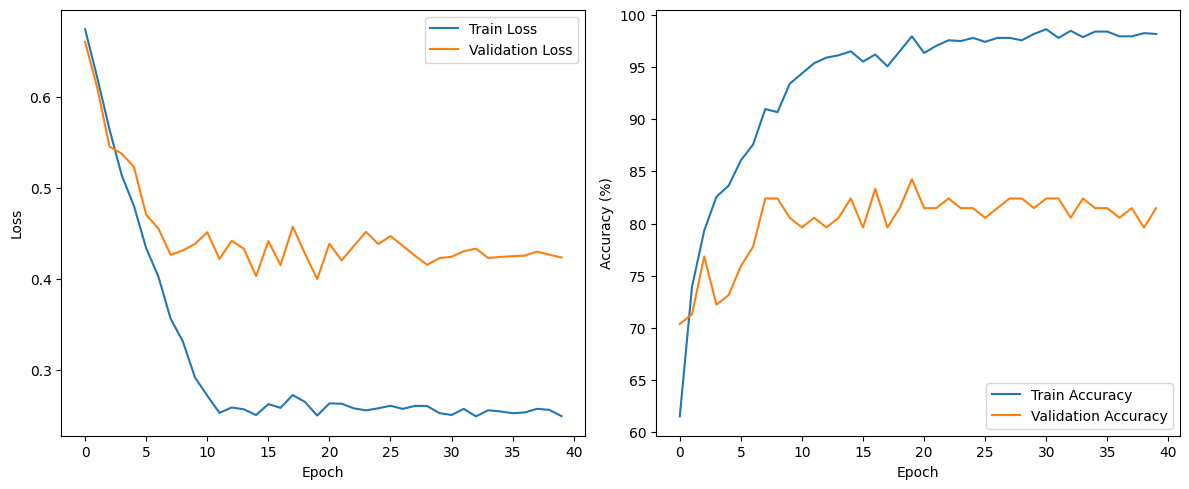

Evaluating model...


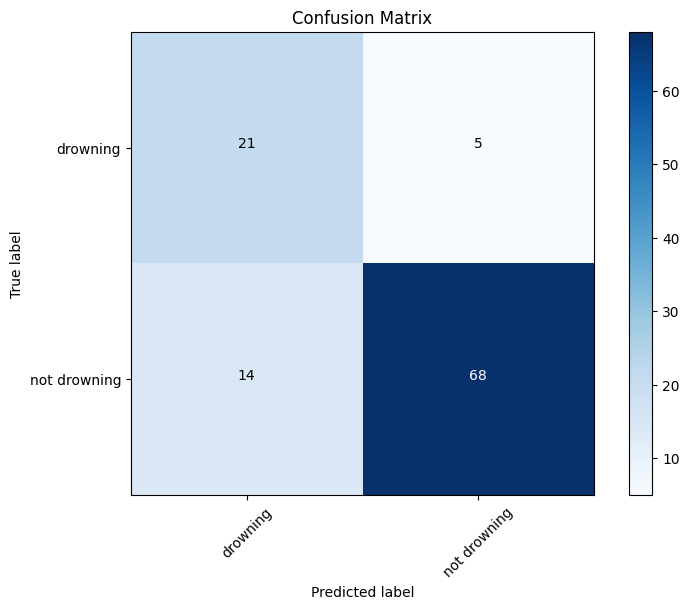

Classification Report:
              precision    recall  f1-score   support

    drowning     0.6000    0.8077    0.6885        26
not drowning     0.9315    0.8293    0.8774        82

    accuracy                         0.8241       108
   macro avg     0.7658    0.8185    0.7830       108
weighted avg     0.8517    0.8241    0.8319       108



In [23]:

model = LightweightDrowningDetectionTransformer(
    feature_dim=256,  
    nhead=4,  
    num_layers=2,
    dropout=0.3
)

print("After Initialize lightweight model")
show_memory_usage()

trained_model = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=100,  
    learning_rate=0.001,
    patience=20
)

print("Evaluating model...")
report, cm = evaluate_model(
    model=model,
    test_loader=test_loader,
    device=device
)


In [25]:
# Save model
torch.save(model.state_dict(), '/kaggle/working/drowning_detection_model_final.pth')
print("Model saved to '/kaggle/working/drowning_detection_model_final.pth'")

Model saved to '/kaggle/working/drowning_detection_model_final.pth'
